In [1]:
import html
import pandas as pd

In [99]:
import geopandas as gpd

In [102]:
import os

In [135]:
from math import ceil

In [104]:
os.chdir('C:\\Users\\rgarcia\\Documents\\Data')

In [2]:
# retira lista de nomes de candidatos a presidente

cands = pd.read_json('https://resultados.tse.jus.br/oficial/ele2022/544/dados/br/br-c0001-e000544-011-f.json').loc['agr', 'carg']
cand_nums = pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(cands, max_level=0)['par'])[0])['cand'])[0])
cand_nums = cand_nums[['n', 'nmu']].dropna()
cand_nums['nmu'] = cand_nums.nmu.apply(lambda x: html.unescape(x).title())
cand_dict = dict(zip(cand_nums.n.to_list(), cand_nums.nmu.to_list()))
cand_dict['22'] = 'Jair Bolsonaro'

In [4]:
# gera lista de códigos de municipios para injetar no JSON

cod_mun = pd.read_csv('https://raw.githubusercontent.com/rafagarc/eleicoes_2022/main/mapas_1o_turno/codigos_IBGE_TSE.csv')
cod_mun['codigo_tse'] = cod_mun.codigo_tse.astype(str).str.zfill(5)
muns = cod_mun.codigo_tse.to_list()
cod_mun['uf'] = cod_mun.uf.str.lower()
list_mun = cod_mun['uf'].astype(str) + cod_mun['codigo_tse'].astype(str).to_list()

In [9]:
# gera chassi para concatenar a tabela
munvotes = pd.DataFrame(columns=['muncod', '13', '14', '21', '27', '44', '12', '16', '15', '22', '30', '80'])

In [14]:
for i in list_mun:
    raw_data = pd.read_json(f'https://resultados.tse.jus.br/oficial/ele2022/544/dados/{i[0:2]}/{i}-c0001-e000544-v.json')
    raw_mun = pd.json_normalize(raw_data['abr']).query('tpabr == "MU"')['cand']
    mun = pd.json_normalize(pd.json_normalize(raw_mun).T[0])
    mun = mun[['n', 'vap']].T
    mun.columns = mun.loc['n']
    mun = mun.drop('n')
    mun.insert(loc=0, column='muncod', value=[i])
    munvotes = pd.concat([munvotes,mun])

In [31]:
munvotes.columns = [cand_dict[i] if i in cand_dict.keys() else i for i in munvotes.columns]

In [20]:
# munvotes.to_csv('munvotes.csv', index=False)

In [41]:
munvotes = munvotes.set_index('muncod')

In [45]:
munvotes = munvotes.astype('int32')

In [141]:
# munvotes.sum()

In [49]:
munvotes['TOTAL'] = munvotes.sum(axis=1)

In [73]:
munvotes_pct = (munvotes.drop(columns='TOTAL').div(munvotes.TOTAL, axis=0)*100).round(2)

In [76]:
munvotes_pct['Bolsonaro - Lula (%)'] = (munvotes_pct['Jair Bolsonaro']-munvotes_pct['Lula']).round(2)

In [86]:
munvotes_pct['Votos válidos'] = munvotes.TOTAL

In [96]:
tse_codes = munvotes_pct.index.to_series().apply(lambda x: int(x[-5:]))

In [97]:
munvotes_pct.insert(loc=0, column='codigo_tse', value=tse_codes)

In [98]:
munvotes_pct

codigo_tse   Lula  Padre Kelmon  Sofia Manzano  Constituinte Eymael  \
muncod                                                                         
ac01120        1120  21.30          0.08           0.00                 0.00   
ac01570        1570  41.12          0.04           0.02                 0.00   
ac01058        1058  29.50          0.03           0.03                 0.02   
ac01007        1007  29.33          0.12           0.03                 0.00   
ac01015        1015  27.12          0.00           0.02                 0.00   
...             ...    ...           ...            ...                  ...   
to96199       96199  71.39          0.00           0.00                 0.00   
to73458       73458  60.18          0.00           0.00                 0.00   
to73237       73237  64.84          0.00           0.14                 0.00   
to96652       96652  60.01          0.04           0.04                 0.06   
to96431       96431  48.57          0.03           0.02                 0.00   

         Soraya Thronicke  Ciro Gomes  Vera  Simone Tebet  Jair Bolsonaro  \
muncod                                                                      
ac01120              0.52        1.64  0.01          2.70           73.59   
ac01570              0.23        0.90  0.10          2.24           55.31   
ac01058              0.37        1.76  0.01          3.51           64.67   
ac01007              0.80        2.71  0.01          4.90           62.03   
ac01015              0.77        2.00  0.00          4.39           65.61   
...                   ...         ...   ...           ...             ...   
to96199              0.43        0.83  0.00          1.48           25.89   
to73458              0.41        1.71  0.00          2.39           35.31   
to73237              0.36        2.17  0.00          3.25           29.24   
to96652              0.17        1.70  0.02          2.32           35.56   
to96431              0.26        1.62  0.00          2.13           47.30   

         Felipe D'Avila  Léo Péricles  Lula - Bolsonaro (%)  Votos válidos  
muncod                                                                      
ac01120            0.15          0.00                 52.29           7118  
ac01570            0.04          0.00                 14.19           4871  
ac01058            0.08          0.01                 35.17          14138  
ac01007            0.07          0.00                 32.70           7263  
ac01015            0.10          0.00                 38.49           6011  
...                 ...           ...                   ...            ...  
to96199            0.00          0.00                -45.50           3998  
to73458            0.00          0.00                -24.87           1464  
to73237            0.00          0.00                -35.60           1385  
to96652            0.08          0.02                -24.45           5296  
to96431            0.06          0.02                 -1.27           6486  

[5570 rows x 14 columns]

In [109]:
tse_ibge = pd.read_csv('https://raw.githubusercontent.com/rafagarc/eleicoes_2022/main/mapas_1o_turno/codigos_IBGE_TSE.csv')

In [112]:
munvotes_agg = tse_ibge.merge(munvotes_pct, how='left', on='codigo_tse')

In [119]:
munvotes_agg['codigo_ibge'] = munvotes_agg.codigo_ibge.astype(str)

In [105]:
munmap = gpd.read_file('BR_Municipios_2021_low_res.json')

In [114]:
munmap = munmap.rename(columns={'CD_MUN':'codigo_ibge'})

In [123]:
votemap = munmap.merge(munvotes_agg, on='codigo_ibge', how='left')

In [137]:
legbound = ceil(max((votemap['Lula - Bolsonaro (%)'].min()*-1, votemap['Lula - Bolsonaro (%)'].max())))

<AxesSubplot:>

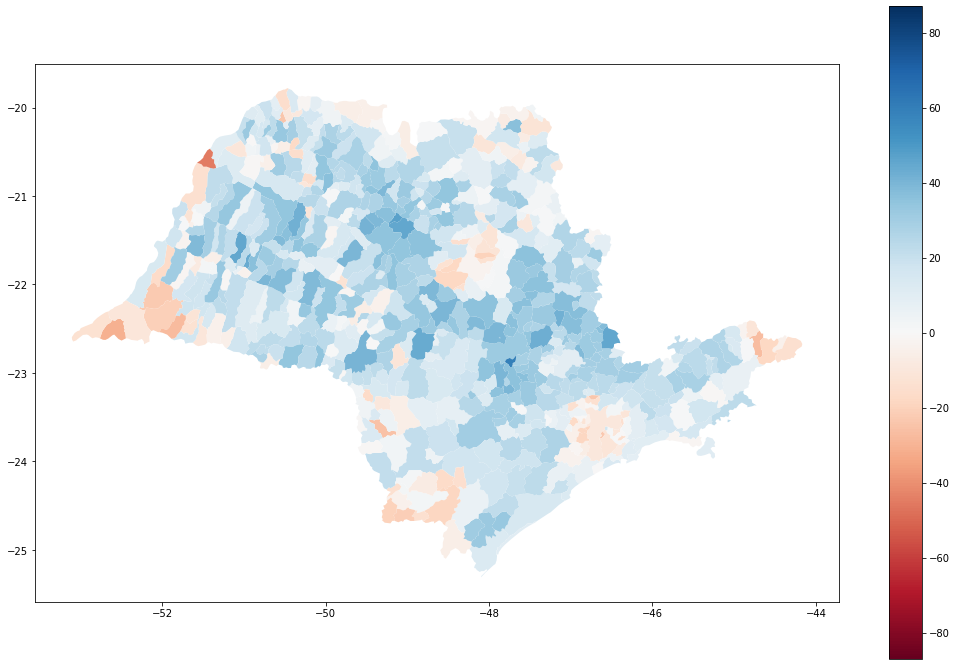

In [182]:
votemap[votemap.codigo_ibge.str.startswith('35')].plot(figsize=(18,12), column='Lula - Bolsonaro (%)', cmap='RdBu', legend=True, vmin=-legbound, vmax=legbound)

In [144]:
votemap[votemap.codigo_ibge.str.startswith('35')]

codigo_ibge            NM_MUN SIGLA  AREA_KM2  \
3267     3500105        Adamantina    SP   411.987   
3268     3500204            Adolfo    SP   211.055   
3269     3500303             Aguaí    SP   474.554   
3270     3500402    Águas da Prata    SP   142.673   
3271     3500501  Águas de Lindóia    SP    60.126   
...          ...               ...   ...       ...   
3907     3557006        Votorantim    SP   184.186   
3908     3557105       Votuporanga    SP   420.703   
3909     3557154          Zacarias    SP   319.056   
3910     3557204         Chavantes    SP   188.727   
3911     3557303      Estiva Gerbi    SP    74.144   

                                               geometry  codigo_tse  uf  \
3267  POLYGON ((-50.99301 -21.43711, -51.02585 -21.4...     61018.0  SP   
3268  POLYGON ((-49.57243 -21.27111, -49.59711 -21.2...     61034.0  SP   
3269  POLYGON ((-46.93973 -21.97809, -46.96211 -21.9...     61050.0  SP   
3270  POLYGON ((-46.69071 -21.83763, -46.70517 -21.8...     61077.0  SP   
3271  POLYGON ((-46.54986 -22.46955, -46.55481 -22.4...     61093.0  SP   
...                                                 ...         ...  ..   
3907  POLYGON ((-47.30746 -23.56101, -47.35432 -23.5...     72435.0  SP   
3908  POLYGON ((-50.00751 -20.33182, -50.03732 -20.3...     72451.0  SP   
3909  POLYGON ((-49.96007 -21.13312, -49.99693 -21.0...     61921.0  SP   
3910  POLYGON ((-49.67729 -23.00875, -49.68644 -22.9...     63371.0  SP   
3911  POLYGON ((-46.89708 -22.20488, -46.92733 -22.1...     61662.0  SP   

             MUNICÍPIO  capital   Lula  ...  Constituinte Eymael  \
3267        ADAMANTINA      0.0  23.89  ...                 0.00   
3268            ADOLFO      0.0  35.70  ...                 0.00   
3269             AGUAÍ      0.0  37.55  ...                 0.01   
3270    ÁGUAS DA PRATA      0.0  33.66  ...                 0.00   
3271  ÁGUAS DE LINDÓIA      0.0  26.83  ...                 0.00   
...                ...      ...    ...  ...                  ...   
3907        VOTORANTIM      0.0  37.04  ...                 0.02   
3908       VOTUPORANGA      0.0  29.71  ...                 0.01   
3909          ZACARIAS      0.0  37.87  ...                 0.00   
3910         CHAVANTES      0.0  37.82  ...                 0.01   
3911      ESTIVA GERBI      0.0  32.93  ...                 0.00   

      Soraya Thronicke  Ciro Gomes  Vera  Simone Tebet  Jair Bolsonaro  \
3267              0.57        2.06  0.01          4.12           68.80   
3268              0.16        1.17  0.00          3.24           59.08   
3269              0.93        2.19  0.02          5.14           53.62   
3270              0.45        2.49  0.04          6.49           56.26   
3271              0.39        2.02  0.00          5.35           64.84   
...                ...         ...   ...           ...             ...   
3907              0.55        2.83  0.04          4.89           53.85   
3908              0.35        2.17  0.02          5.03           62.07   
3909              0.39        0.94  0.00          3.53           57.00   
3910              0.40        2.10  0.06          4.50           54.72   
3911              0.32        1.92  0.01          4.92           59.24   

      Felipe D'Avila  Léo Péricles  Lula - Bolsonaro (%)  Votos válidos  
3267            0.41          0.02                 44.91        19663.0  
3268            0.55          0.00                 23.38         3084.0  
3269            0.42          0.05                 16.07        17036.0  
3270            0.48          0.04                 22.60         4623.0  
3271            0.45          0.05                 38.01        10915.0  
...              ...           ...                   ...            ...  
3907            0.61          0.05                 16.81        68763.0  
3908            0.54          0.04                 32.36        52435.0  
3909            0.17          0.06                 19.13         1814.0  
3910     